# Team Zip-G-Force Data Filters
## Post processing for acceleration data

1. Import data analysis libraries
2. Import and store the data as “RAW DATA”
3. Run the aliased data through a post processing filter and store data as "BUTTERWORTH FILTERED DATA"
 - The F2137 filter is a butterworth 4 pole
4. The Invensesense MPU-9250 reports accelerometer data using a 16-bit value, or 65536 counts. To convert the raw data to “g” units and “degree-seconds”, accelerometer data is divided by 2048 and gyroscope data is divided by 65.536. Store final data as "MANIPULATED DATA"
5. Using the video duration data (estimated values), extract the runs from the combined data.
 - Duration to trim until start of first run
 - Run duration
 - Transit duration
 - Repeat
5. Display post-processed data as a set of graphs
 - Show runs individually
 - Show runs compiled with standard deviation (however this may not be the best plot because of the swing/rotation of the user)


### Import Libraries

In [18]:
#Imports
import pandas as pd
import numpy as np
import glob, os

#For filtering and plotting graphs
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from scipy.signal import butter, lfilter, freqz
from math import pi

#Ignore warning
import warnings
warnings.filterwarnings("ignore")

In [19]:
#Static Variables
colnames_HAM_IMU = ['Time',
            'Ax', 'Ay', 'Az', 
            'Gx', 'Gy', 'Gz', 
            'Qw', 'Qx', 'Qy', 'Qz', 
            'Mx', 'My', 'Mz', 'T',
            'Date Time'] 

colnames_HAM_IMU_ALT = ['Time',
            'Ax', 'Ay', 'Az', 
            'Gx', 'Gy', 'Gz', 
            'Qw', 'Qx', 'Qy', 'Qz', 
            'Mx', 'My', 'Mz', 'P', 'T',
            'Date Time'] 

files = glob.glob('DATA-*')

#Filepaths
ttea_v1_head = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061518 - Treetop Eco Adventure/Accelerations/1 - Head/'
ttea_v1_neck = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061518 - Treetop Eco Adventure/Accelerations/2 - Neck C7/'
ttea_v1_shoulder = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061518 - Treetop Eco Adventure/Accelerations/3 - Left Shoulder/'
ttea_v1_heart = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061518 - Treetop Eco Adventure/Accelerations/4 - Heart/'
ttea_v1_com = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061518 - Treetop Eco Adventure/Accelerations/5 - COM Harness/'

bmfp_v2_head = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061918 - Blue Mountain/Accelerations/1 - Head/'
bmfp_v2_neck = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061918 - Blue Mountain/Accelerations/2 - Neck C7/'
bmfp_v2_shoulder = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061918 - Blue Mountain/Accelerations/3 - Left Shoulder/'
bmfp_v2_heart = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061918 - Blue Mountain/Accelerations/4 - Heart/'
bmfp_v2_com = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/061918 - Blue Mountain/Accelerations/5 - COM Harness/'

bmfp_v3_head = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062018 - Blue Mountain/Accelerations/1 - Head/'
bmfp_v3_neck = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062018 - Blue Mountain/Accelerations/2 - Neck C7/'
bmfp_v3_shoulder = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062018 - Blue Mountain/Accelerations/3 - Left Shoulder/'
bmfp_v3_heart = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062018 - Blue Mountain/Accelerations/4 - Heart/'
bmfp_v3_com = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062018 - Blue Mountain/Accelerations/5 - COM Harness/'

bmfp_v4_head = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062118 - Blue Mountain/Accelerations/1 - Head/'
bmfp_v4_neck = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062118 - Blue Mountain/Accelerations/2 - Neck C7/'
bmfp_v4_shoulder = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062118 - Blue Mountain/Accelerations/3 - Left Shoulder/'
bmfp_v4_heart = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062118 - Blue Mountain/Accelerations/4 - Heart/'
bmfp_v4_com = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/062118 - Blue Mountain/Accelerations/5 - COM Harness/'

#For debugging purposes - Checkpoint
#Check is file path exists. In the following code, you will need to substitute the correspoding file path. 
os.path.exists('/Users/shellyginelle/Data/1 - Head/DATA-001.csv')
os.path.exists(bmfp_v4_head)

True

### Import Data
Every .CSV file records for 15 mins. The idea is to concatenate all .CSV files for each specific accelerometer positions then chop the sections into set of events: 
1. On Zip Line
 - Start
 - Arrival at Brake Mechanism
2. Offloading - Figure out the time it took for you to get back onto the Zip Line of choice

In [20]:
'''
1. Read all HEAD data files
'''
head_raw_dir = os.chdir(bmfp_v4_head)
head_results = pd.DataFrame([], columns=colnames_HAM_IMU)

for counter, file in enumerate(files):
    head_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, engine='python')
    #Append the results into one dataframe
    head_results = head_results.append(head_df)

#Save the results into a separate combined .csv
head_results.to_csv(bmfp_v4_head + 'COMBINED_HEAD_DATA.csv')

#Read combined data, rename columns and print data
head_raw_df = pd.read_csv(bmfp_v4_head + 'COMBINED_HEAD_DATA.csv', 
                         skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

#print combined dataframe
#head_raw_df

In [21]:
'''
2. Read all NECK C7 data files
'''
neck_raw_dir = os.chdir(bmfp_v4_neck)
neck_results = pd.DataFrame([], columns=colnames_HAM_IMU)

for counter, file in enumerate(files):
    neck_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, engine='python')
    #Append the results into one dataframe
    neck_results = neck_results.append(neck_df)

#Save the results into a separate combined .csv
neck_results.to_csv(bmfp_v4_neck + 'COMBINED_NECK_DATA.csv')

#Read combined data, rename columns and print data
neck_raw_df = pd.read_csv(bmfp_v4_neck + 'COMBINED_NECK_DATA.csv', 
                  skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

#print combined dataframe
#neck_raw_df

In [22]:
'''
3. Read all SHOULDER data files
'''
shoulder_raw_dir = os.chdir(bmfp_v4_shoulder)
shoulder_results = pd.DataFrame([], columns=colnames_HAM_IMU_ALT)

for counter, file in enumerate(files):
    shoulder_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7,8], sep=',', names=colnames_HAM_IMU_ALT, engine='python')
    #Append the results into one dataframe
    shoulder_results = shoulder_results.append(shoulder_df)

#Save the results into a separate combined .csv
shoulder_results.to_csv(bmfp_v4_shoulder + 'COMBINED_SHOULDER_DATA.csv')

#Read combined data, rename columns and print data
shoulder_raw_df = pd.read_csv(bmfp_v4_shoulder + 'COMBINED_SHOULDER_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU_ALT, header=None, engine='python')

#print combined dataframe
#shoulder_raw_df

In [23]:
'''
4. Read all HEART data files
'''
heart_raw_dir = os.chdir(bmfp_v4_heart)
heart_results = pd.DataFrame([], columns=colnames_HAM_IMU)

for counter, file in enumerate(files):
    heart_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7,8], sep=',', names=colnames_HAM_IMU, engine='python')
    #Append the results into one dataframe
    heart_results = heart_results.append(heart_df)

#Save the results into a separate combined .csv
heart_results.to_csv(bmfp_v4_heart + 'COMBINED_HEART_DATA.csv')

#Read combined data, rename columns and print data
heart_raw_df = pd.read_csv(bmfp_v4_heart + 'COMBINED_HEART_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

#print combined dataframe
#heart_raw_df

In [24]:
'''
5. Read all COM Harness data files
'''
com_raw_dir = os.chdir(bmfp_v4_com)
com_results = pd.DataFrame([], columns=colnames_HAM_IMU)

for counter, file in enumerate(files):
    com_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, engine='python')
    #Append the results into one dataframe
    com_results = com_results.append(com_df)

#Save the results into a separate combined .csv
com_results.to_csv(bmfp_v4_com + 'COMBINED_COM_DATA.csv')

#Read combined data, rename columns and print data
com_raw_df = pd.read_csv(bmfp_v4_com + 'COMBINED_COM_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

#print combined dataframe
#com_raw_df

In [25]:
#Create temp df so we don't alter the raw data values, will need for plots later
head_raw_temp_df = head_raw_df
neck_raw_temp_df = neck_raw_df
shoulder_raw_temp_df = shoulder_raw_df
heart_raw_temp_df = heart_raw_df
com_raw_temp_df = com_raw_df

### Filter Data

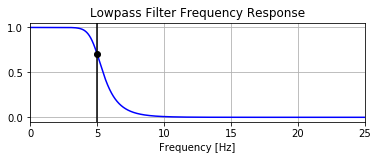

In [26]:
#Run the aliased data through a post processing butterworth filter, save results as post processed data - pp
'''
head_pp_df
neck_pp_df
shoulder_pp_df
heart_pp_df
com_pp_df
'''

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs #The Nyquist frequency is half the sampling rate.
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 50.0       # sample rate, Hz
cutoff = 5.0  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

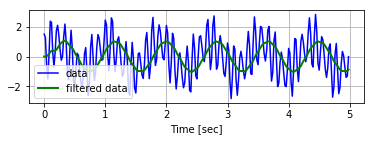

In [27]:
# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [28]:
# The data to be filtered is as follows:
cols_to_filter = ['Ax', 'Ay', 'Az', 
            'Gx', 'Gy', 'Gz', 
            'Qw', 'Qx', 'Qy', 'Qz'] 

# Filter the data, and plot both the original and filtered signals.
for cols in cols_to_filter:
    head_raw_temp_df[cols] = butter_lowpass_filter(head_raw_temp_df[cols], cutoff, fs, order)
    neck_raw_temp_df[cols] = butter_lowpass_filter(neck_raw_temp_df[cols], cutoff, fs, order)
    shoulder_raw_temp_df[cols] = butter_lowpass_filter(shoulder_raw_temp_df[cols], cutoff, fs, order)
    heart_raw_temp_df[cols] = butter_lowpass_filter(heart_raw_temp_df[cols], cutoff, fs, order)
    com_raw_temp_df[cols] = butter_lowpass_filter(com_raw_temp_df[cols], cutoff, fs, order)

In [29]:
#Save dataframe into new .csv
head_raw_temp_df.to_csv(bmfp_v4_head + 'BUTTERWORTH_FLTR_HEAD_DATA.csv')
head_butterflt_df = pd.read_csv(bmfp_v4_head + 'BUTTERWORTH_FLTR_HEAD_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

neck_raw_temp_df.to_csv(bmfp_v4_neck + 'BUTTERWORTH_FLTR_NECK_DATA.csv')
neck_butterflt_df = pd.read_csv(bmfp_v4_neck + 'BUTTERWORTH_FLTR_NECK_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

shoulder_raw_temp_df.to_csv(bmfp_v4_shoulder + 'BUTTERWORTH_FLTR_SHOULDER_DATA.csv')
shoulder_butterflt_df = pd.read_csv(bmfp_v4_shoulder + 'BUTTERWORTH_FLTR_SHOULDER_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

heart_raw_temp_df.to_csv(bmfp_v4_heart + 'BUTTERWORTH_FLTR_HEART_DATA.csv')
heart_butterflt_df = pd.read_csv(bmfp_v4_heart + 'BUTTERWORTH_FLTR_HEART_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

com_raw_temp_df.to_csv(bmfp_v4_com + 'BUTTERWORTH_FLTR_COM_DATA.csv')
com_butterflt_df = pd.read_csv(bmfp_v4_com + 'BUTTERWORTH_FLTR_COM_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

#For debugging purposes - Checkpoint
#Print last dataframe to show code has completed
#com_butterflt_df

### Calculate Data

The Invensesense MPU-9250 reports accelerometer data using a 16-bit value, or 65536 counts. To convert the raw data to “g” units and “degree-seconds”, accelerometer data is divided by 2048 and gyroscope data is divided by 65.536. 

In [30]:
#Divide columns Ax, Ay, Az by 2048
#Divide Gx, Gy, Gz by 65.536
acceleration_cols = ['Ax', 'Ay', 'Az']
gyroscope_cols = ['Gx', 'Gy', 'Gz']
count_g = 2048
degree_sec = 65.536
is_int = np.int64 
if_float = np.float64


for a_cols in acceleration_cols:
    
    if (head_butterflt_df[a_cols].dtype == np.float64 
        and neck_butterflt_df[a_cols].dtype == np.float64 
        and shoulder_butterflt_df[a_cols].dtype == np.float64 
        and heart_butterflt_df[a_cols].dtype == np.float64
        and com_butterflt_df[a_cols].dtype == np.float64):
        
        head_butterflt_df[a_cols] = head_butterflt_df[a_cols].divide(count_g)
        neck_butterflt_df[a_cols] = neck_butterflt_df[a_cols].divide(count_g)
        shoulder_butterflt_df[a_cols] = shoulder_butterflt_df[a_cols].divide(count_g)
        heart_butterflt_df[a_cols] = heart_butterflt_df[a_cols].divide(count_g)
        com_butterflt_df[a_cols] = com_butterflt_df[a_cols].divide(count_g)   

for g_cols in gyroscope_cols:
    if (head_butterflt_df[g_cols].dtype == np.float64 
        and neck_butterflt_df[g_cols].dtype == np.float64 
        and shoulder_butterflt_df[g_cols].dtype == np.float64 
        and heart_butterflt_df[g_cols].dtype == np.float64
        and com_butterflt_df[g_cols].dtype == np.float64):
        
        head_butterflt_df[g_cols] = head_butterflt_df[g_cols].divide(degree_sec)
        neck_butterflt_df[g_cols] = neck_butterflt_df[g_cols].divide(degree_sec)
        shoulder_butterflt_df[g_cols] = shoulder_butterflt_df[g_cols].divide(degree_sec)
        heart_butterflt_df[g_cols] = heart_butterflt_df[g_cols].divide(degree_sec)
        com_butterflt_df[g_cols] = com_butterflt_df[g_cols].divide(degree_sec)

In [31]:
#Save dataframe into new .csv
head_butterflt_df.to_csv(bmfp_v4_head + 'MANIPULATED_HEAD_DATA.csv')
head_mnptd_df = pd.read_csv(bmfp_v4_head + 'MANIPULATED_HEAD_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

neck_butterflt_df.to_csv(bmfp_v4_neck + 'MANIPULATED_NECK_DATA.csv')
neck_mnptd_df = pd.read_csv(bmfp_v4_neck + 'MANIPULATED_NECK_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

shoulder_butterflt_df.to_csv(bmfp_v4_shoulder + 'MANIPULATED_SHOULDER_DATA.csv')
shoulder_mnptd_df = pd.read_csv(bmfp_v4_shoulder + 'MANIPULATED_SHOULDER_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

heart_butterflt_df.to_csv(bmfp_v4_heart + 'MANIPULATED_HEART_DATA.csv')
heart_mnptd_df = pd.read_csv(bmfp_v4_heart + 'MANIPULATED_HEART_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

com_butterflt_df.to_csv(bmfp_v4_com + 'MANIPULATED_COM_DATA.csv')
com_mnptd_df = pd.read_csv(bmfp_v4_com + 'MANIPULATED_COM_DATA.csv', 
                 skiprows=[0], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

#For debugging purposes - Checkpoint
#Print last dataframe to show code has completed
#com_mnptd_df

#### This part will be added through Tableau Data Visualization

### Plot Data
1. Acceleration
2. G-Force
3. Quaternion

### Data Analysis

#### Acceleration & Gyroscope
1. MAX vs MIN experienced
2. Dependent on the MAX and MIN recorded, what was the longest duration of that acceleration experienced?

#### Quarternion
1. What was the position of the test participant? This will should be mapped to the acceleration experienced.

In [40]:
'''
Read all video duration data files

Note: 50 samples per second, 3000 samples per minute
'''
#Variables
samples_per_ms = 5
samples_per_second = 50
samples_per_minute = 3000
convert_to_seconds = 86400

avg_swing_time = samples_per_second + (samples_per_ms*3)
avg_run_time = samples_per_second * 13 

video_visit4_data = '/Users/shellyginelle/Documents/GitHub/zipline-acceleration-analysis/Video Data Analysis/Video Data Analysis - Visit 4.csv'
colnames_video_data = ['Visit', 'Run', 
                       'Run Start', 'Brake Start', 'Run End',
                       'Run to Brake Duration','Brake Swing Duration', 'Transit Duration', 
                       'Avg Run Duration', 'Avg Transit Duration'] 

#Read and print data
video_visit4_df = pd.read_csv(video_visit4_data, skiprows=[0], sep=',', 
                       names=colnames_video_data, header=None, engine='python')

#print combined dataframe
video_visit4_df

,Visit,Run,Run Start,Brake Start,Run End,Run to Brake Duration,Brake Swing Duration,Transit Duration,Avg Run Duration,Avg Transit Duration
0,Start Time,NaN,NaN,0.011172,NaN,NaN,NaN,NaN,NaN,NaN
1,EST Start Time Head,NaN,0.001413,0.009758,NaN,NaN,NaN,NaN,NaN,NaN
2,EST Start Time Neck,NaN,0.001238,0.009934,NaN,NaN,NaN,NaN,NaN,NaN
3,EST Start Time Shoulder,NaN,0.001657,0.009515,NaN,NaN,0.000164,NaN,NaN,NaN
4,EST Start Time Heart,NaN,0.001658,0.009514,NaN,NaN,0.000152,NaN,NaN,NaN
5,EST Start Time COM,NaN,0.001518,0.009653,NaN,NaN,0.000012,NaN,NaN,NaN
6,4,1.0,0.011172,0.011324,0.011336,0.000152,0.000012,0.003566,0.000149,0.0036
7,4,2.0,0.014890,0.015052,0.015074,0.000162,0.000022,0.003392,NaN,NaN
8,4,3.0,0.018444,0.018583,0.018595,0.000139,0.000012,0.003253,NaN,NaN
9,4,4.0,0.021836,0.021986,0.021998,0.000150,0.000012,0.003264,NaN,NaN


In [74]:
def calculate_row_count(value_to_convert):
    row_count = float(value_to_convert) * convert_to_seconds * samples_per_second
    return int(row_count)

trim_duration = calculate_row_count(video_visit4_df.loc[1, 'Run Start'])

run1_duration = calculate_row_count(video_visit4_df.loc[6, 'Run to Brake Duration'])
run2_duration = calculate_row_count(video_visit4_df.loc[7, 'Run to Brake Duration'])
run3_duration = calculate_row_count(video_visit4_df.loc[8, 'Run to Brake Duration'])
run4_duration = calculate_row_count(video_visit4_df.loc[9, 'Run to Brake Duration'])
run5_duration = calculate_row_count(video_visit4_df.loc[10, 'Run to Brake Duration'])
run6_duration = calculate_row_count(video_visit4_df.loc[11, 'Run to Brake Duration'])
run7_duration = calculate_row_count(video_visit4_df.loc[12, 'Run to Brake Duration'])

transit1_duration = calculate_row_count(video_visit4_df.loc[6, 'Transit Duration'])
transit2_duration = calculate_row_count(video_visit4_df.loc[7, 'Transit Duration'])
transit3_duration = calculate_row_count(video_visit4_df.loc[8, 'Transit Duration'])
transit4_duration = calculate_row_count(video_visit4_df.loc[9, 'Transit Duration'])
transit5_duration = calculate_row_count(video_visit4_df.loc[10, 'Transit Duration'])
transit6_duration = calculate_row_count(video_visit4_df.loc[11, 'Transit Duration'])

run1_start = trim_duration + run1_duration
run1_end = run1_start + 30

run2_start = transit1_duration + run2_duration
run2_end = run2_start + 50

run3_start = transit2_duration + run3_duration
run3_end = run3_start + 50

run4_start = transit3_duration + run4_duration
run4_end = run4_start + 50

run5_start = transit4_duration + run5_duration
run5_end = run5_start + 50

run6_start = transit5_duration + run6_duration
run6_end = run4_start + 50

run7_start = transit6_duration + run7_duration
run7_end = run4_start + 50

print(run1_start, run1_end)

6762 6792


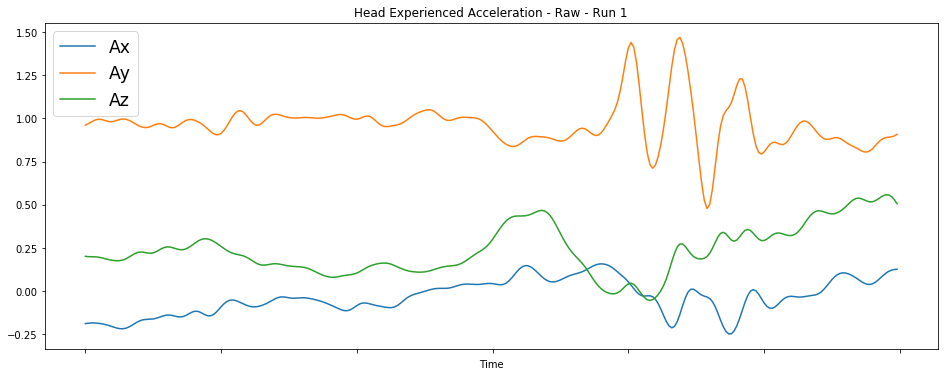

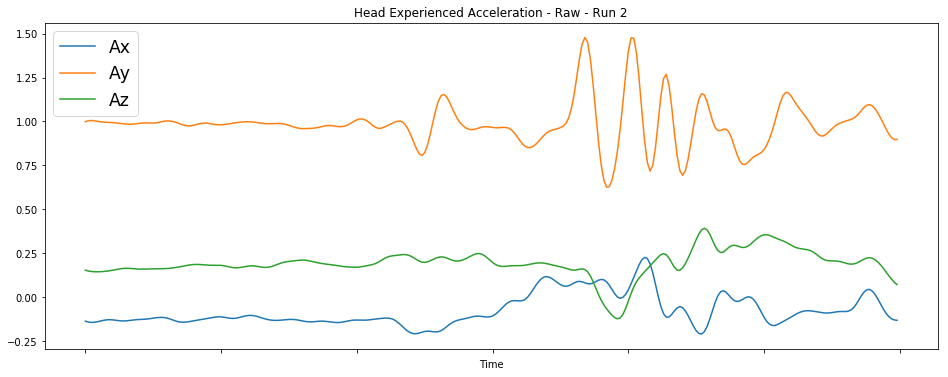

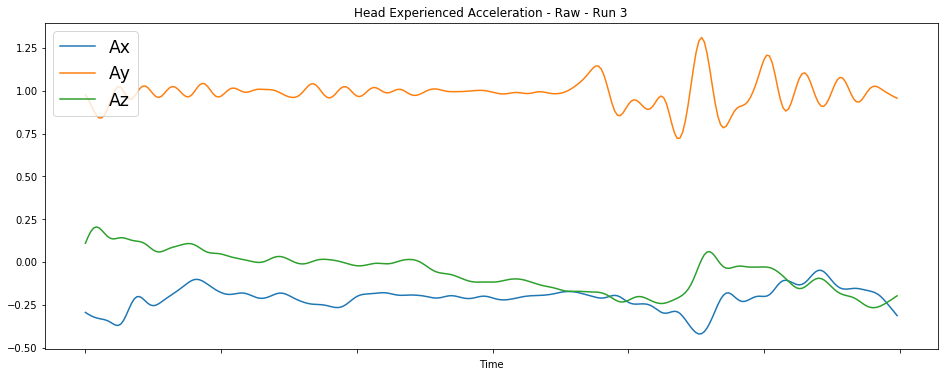

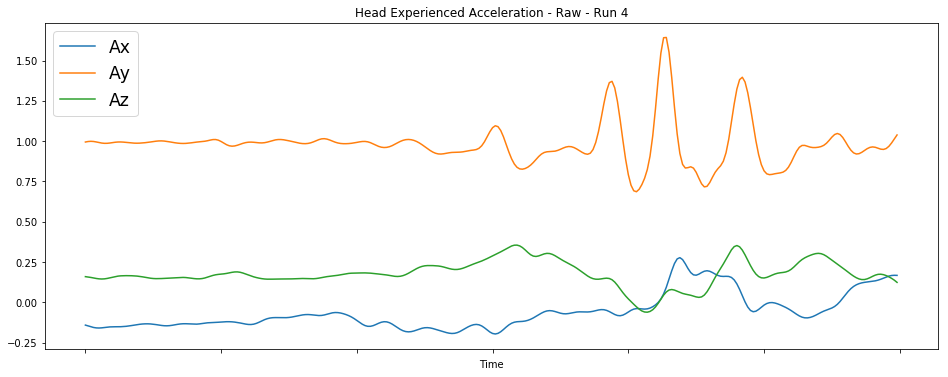

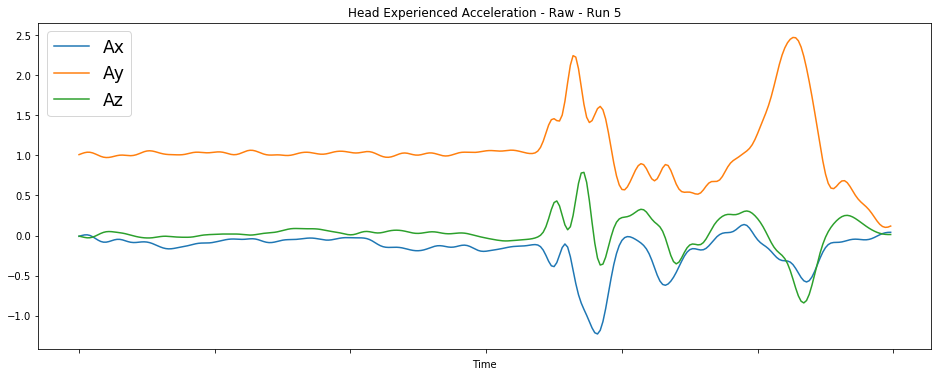

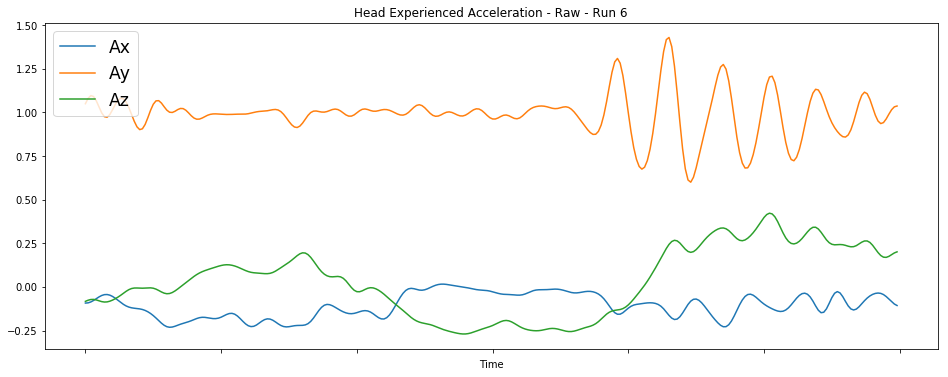

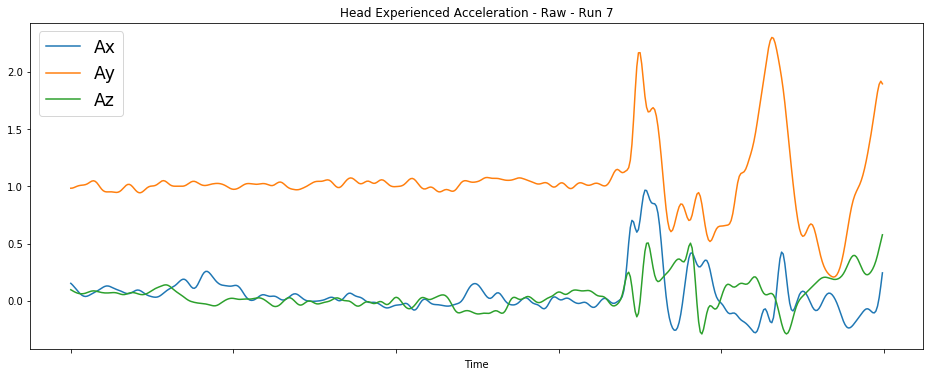

In [271]:
#3000*4.5 = 13500
#transit to first run = head_mnptd_df.iloc[3370:4800] ?

try:
    # Run 1
    head_run1_plot = head_mnptd_df.iloc[6000:6300].plot(
        title = 'Head Experienced Acceleration - Raw - Run 1',  
        x = 'Time', y = acceleration_cols, figsize = (16,6))
    head_run1_plot.legend(loc=2, fontsize = 'xx-large')
    
    # Run 2
    head_run2_plot = head_mnptd_df.iloc[22050:22350].plot(
        title = 'Head Experienced Acceleration - Raw - Run 2',  
        x = 'Time', y = acceleration_cols, figsize = (16,6))
    head_run2_plot.legend(loc=2, fontsize = 'xx-large')
    
    # Run 3
    head_run3_plot = head_mnptd_df.iloc[35950:36250].plot(
        title = 'Head Experienced Acceleration - Raw - Run 3',  
        x = 'Time', y = acceleration_cols, figsize = (16,6))
    head_run3_plot.legend(loc=2, fontsize = 'xx-large')

    # Run 4
    head_run4_plot = head_mnptd_df.iloc[52350:52650].plot(
        title = 'Head Experienced Acceleration - Raw - Run 4',  
        x = 'Time', y = acceleration_cols, figsize = (16,6))
    head_run4_plot.legend(loc=2, fontsize = 'xx-large')

    # Run 5
    head_run5_plot = head_mnptd_df.iloc[67850:68150].plot(
        title = 'Head Experienced Acceleration - Raw - Run 5',  
        x = 'Time', y = acceleration_cols, figsize = (16,6))
    head_run5_plot.legend(loc=2, fontsize = 'xx-large')
    
    # Run 6
    head_run6_plot = head_mnptd_df.iloc[81500:81800].plot(
        title = 'Head Experienced Acceleration - Raw - Run 6',  
        x = 'Time', y = acceleration_cols, figsize = (16,6))
    head_run6_plot.legend(loc=2, fontsize = 'xx-large')

    # Run 7
    head_run7_plot = head_mnptd_df.iloc[98000:98500].plot(
        title = 'Head Experienced Acceleration - Raw - Run 7',  
        x = 'Time', y = acceleration_cols, figsize = (16,6))
    head_run7_plot.legend(loc=2, fontsize = 'xx-large')
    
except TypeError or NameError:
    pass